In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
#adjustable variables
yearly_data_path = 'path/to/joined/yearly/data'
modelling_year = 2001
delay_group_threshold = 4

In [3]:
year_df = pd.read_csv(f'{yearly_data_path}{modelling_year}.csv')

In [4]:
def bin_time(crs_time):
    bin_dict = {0: '00-06', 1: '06-12', 2: '12-18', 3: '18-00'}
    if crs_time == 2400:
        return '18-00'
    return bin_dict[crs_time // 600]

def get_season(month):
    season_dict = {(1,2,3): 'spring', (4,5,6): 'summer', (7,8,9): 'autumn', (10,11,12): 'winter'}
    for key, val in season_dict.items():
        if month in key:
            return val

In [5]:
#preprocessing
arr_use_cols = ['MONTH', 'DAY_OF_WEEK', 'CRS_ARR_TIME', 'DISTANCE', 'PRCP_DEST', 'SNOW_DEST', 'SNWD_DEST', 'TMAX_DEST', 'TMIN_DEST', 'ARR_DELAY_GROUP']
arr_df = year_df[arr_use_cols]
arr_df = arr_df[pd.notnull(arr_df['ARR_DELAY_GROUP'])]
arr_df['HAS_ARR_DELAY'] = arr_df['ARR_DELAY_GROUP'].apply(lambda x: 1 if x >= delay_group_threshold else 0)
arr_df['CRS_ARR_BIN'] = arr_df['CRS_ARR_TIME'].apply(bin_time)
arr_df['SEASON'] = arr_df['MONTH'].apply(get_season)
arr_df = arr_df.astype({'DAY_OF_WEEK': 'category'})

In [6]:
#train-test split
arr_regression_cols = ['SEASON', 'DAY_OF_WEEK', 'CRS_ARR_BIN', 'DISTANCE', 'PRCP_DEST', 'SNOW_DEST', 'SNWD_DEST', 'TMAX_DEST', 'TMIN_DEST', 'HAS_ARR_DELAY']
arr_regression_df = arr_df[arr_regression_cols]
arr_regression_df = arr_regression_df.dropna()
arr_X = pd.get_dummies(arr_regression_df.drop('HAS_ARR_DELAY', axis=1))
arr_y = arr_regression_df['HAS_ARR_DELAY']
arr_X_train, arr_X_test, arr_y_train, arr_y_test = train_test_split(arr_X, arr_y, test_size = 0.2)

In [7]:
# Ridge ARR

alphas = 10**np.linspace(10,-2,100)*0.5

ridge_arr_cv = RidgeCV(alphas=alphas)
ridge_arr_cv.fit(arr_X_train, arr_y_train)
print('best alpha: ' + ridge_arr_cv.alpha_.astype(str))

ridge_arr = Ridge(alpha = ridge_arr_cv.alpha_)
ridge_arr.fit(arr_X_train, arr_y_train)
print('MSE: ' + mean_squared_error(arr_y_test, ridge_arr.predict(arr_X_test)).astype(str))

best alpha: 616.4233697210329
MSE: 0.044112463606545804


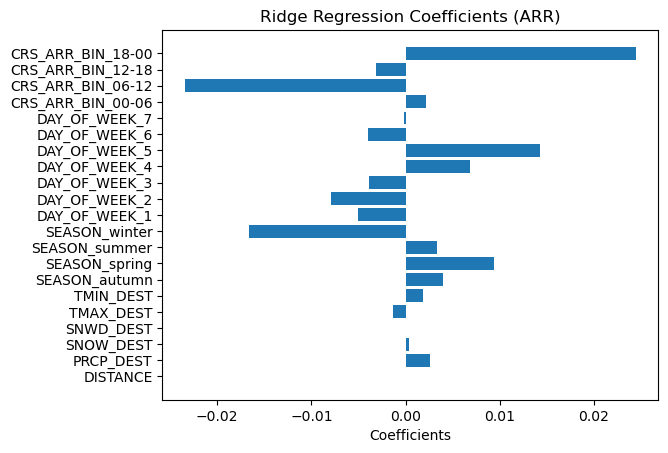

In [8]:
# Ridge ARR plot

fig, ax = plt.subplots()
ax.barh(ridge_arr.feature_names_in_, ridge_arr.coef_)
ax.set_xlabel('Coefficients')
ax.set_title('Ridge Regression Coefficients (ARR)')
plt.show()